In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D
from keras.utils import to_categorical

2024-08-16 14:39:39.766934: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 14:39:39.767067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 14:39:39.932473: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load the CSV file
data = pd.read_csv('/kaggle/input/alzheimers-disease-dataset/alzheimers_disease_data.csv')  # Replace 'your_file.csv' with the actual path to your CSV file
print(data.columns)

# Check for any null values and handle them (e.g., fill or drop)
data = data.dropna()  # or you can use data.fillna(value)

# Separate features and target
X = data.drop(columns=['Diagnosis'])
y = data['Diagnosis']

# Ensure all data in X is numeric
X = pd.get_dummies(X)

# Convert all values to float32
X = X.astype('float32')

# Encode the target variable (if it's binary)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize/Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data to add a channel dimension (needed for Conv1D)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# Compute class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

Index(['PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
       'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
       'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
       'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP',
       'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
       'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
       'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
       'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
       'Forgetfulness', 'Diagnosis', 'DoctorInCharge'],
      dtype='object')


In [3]:
# Define a deeper CNN model
model = Sequential()

# Add multiple Conv1D and MaxPooling1D layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy loss
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model with class weights
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, class_weight=class_weights_dict)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 32, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 14, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 5, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,505 (771.50 KB)

 Trainable params: 197,505 (771.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4892 - loss: 0.7269 - val_accuracy: 0.6163 - val_loss: 0.6869
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5444 - loss: 0.6827 - val_accuracy: 0.6192 - val_loss: 0.6875
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4987 - loss: 0.7009 - val_accuracy: 0.6105 - val_loss: 0.6921
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5030 - loss: 0.6939 - val_accuracy: 0.6192 - val_loss: 0.6842
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5693 - loss: 0.6836 - val_accuracy: 0.3808 - val_loss: 0.6944
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5108 - loss: 0.6904 - val_accuracy: 0.6192 - val_loss: 0.6898
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5002 - loss: 0.6965 - val_accuracy: 0.6192 - val_loss: 0.6882
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5853 - loss: 0.6780 - val_accuracy: 0.5959 - v

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8947 - loss: 0.3246 
Test Accuracy: 89.07%


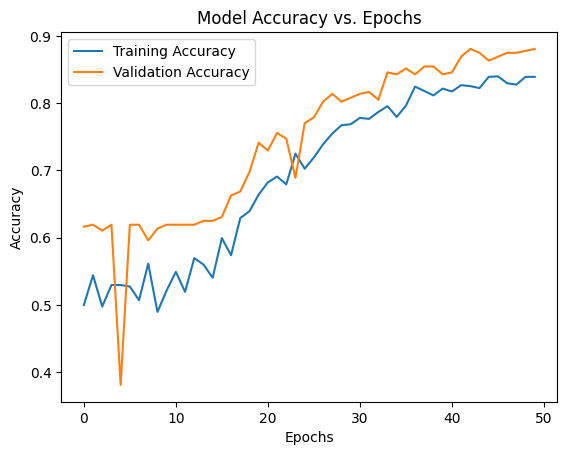

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
   Actual  Predicted
0       0          0
1       0          0
2       0          0
3       0          0
4       0          0


In [4]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plot accuracy vs. iterations (epochs)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Making predictions on new data
predictions = model.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int).flatten()  # Binary threshold at 0.5
actual_classes = y_test

# Compare predictions with actual values
comparison = pd.DataFrame({'Actual': actual_classes, 'Predicted': predicted_classes})
print(comparison.head())